Imports

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import seaborn as sns
from tensorflow import keras
from keras import layers
from keras.layers import Dense,Dropout,SimpleRNN,LSTM
from keras.models import Sequential
import sklearn.preprocessing
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.linear_model import LinearRegression

Import Dataset

In [3]:
# Import dataset
data = pd.read_csv('LD2011_2014.txt', sep=';', thousands='.', decimal=',')

# Show first five rows
data.head()

Datetime  MT_001  MT_002  MT_003  MT_004  MT_005  MT_006  \
0  2011-01-01 00:15:00     0.0     0.0     0.0     0.0     0.0     0.0   
1  2011-01-01 00:30:00     0.0     0.0     0.0     0.0     0.0     0.0   
2  2011-01-01 00:45:00     0.0     0.0     0.0     0.0     0.0     0.0   
3  2011-01-01 01:00:00     0.0     0.0     0.0     0.0     0.0     0.0   
4  2011-01-01 01:15:00     0.0     0.0     0.0     0.0     0.0     0.0   

   MT_007  MT_008  MT_009  ...  MT_361  MT_362  MT_363  MT_364  MT_365  \
0     0.0     0.0     0.0  ...     0.0     0.0     0.0     0.0     0.0   
1     0.0     0.0     0.0  ...     0.0     0.0     0.0     0.0     0.0   
2     0.0     0.0     0.0  ...     0.0     0.0     0.0     0.0     0.0   
3     0.0     0.0     0.0  ...     0.0     0.0     0.0     0.0     0.0   
4     0.0     0.0     0.0  ...     0.0     0.0     0.0     0.0     0.0   

   MT_366  MT_367  MT_368  MT_369  MT_370  
0     0.0     0.0     0.0     0.0     0.0  
1     0.0     0.0     0.0     0.0     0.0  
2     0.0     0.0     0.0     0.0     0.0  
3     0.0     0.0     0.0     0.0     0.0  
4     0.0     0.0     0.0     0.0     0.0  

[5 rows x 371 columns]

Understand our data

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 140256 entries, 0 to 140255
Columns: 371 entries, Datetime to MT_370
dtypes: float64(370), object(1)
memory usage: 397.0+ MB


In [5]:
# We observe that datetime column is an object type column, so we convert it to datetime time
data['Datetime'] = pd.to_datetime(data['Datetime'])

# Dimensionality of dataset
data.shape

(140256, 371)

Splitting datetime into date column and time column

In [6]:
data['Date'] = [d.date() for d in data['Datetime']]
data['Time'] = [d.time() for d in data['Datetime']]
data['Year'] = data['Datetime'].dt.year

# Drop datetime (it is more preferable to have the time seperately since we are hourly based working)
data = data.drop(columns=['Datetime'])
data.head()

MT_001  MT_002  MT_003  MT_004  MT_005  MT_006  MT_007  MT_008  MT_009  \
0     0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0   
1     0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0   
2     0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0   
3     0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0   
4     0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0   

   MT_010  ...  MT_364  MT_365  MT_366  MT_367  MT_368  MT_369  MT_370  \
0     0.0  ...     0.0     0.0     0.0     0.0     0.0     0.0     0.0   
1     0.0  ...     0.0     0.0     0.0     0.0     0.0     0.0     0.0   
2     0.0  ...     0.0     0.0     0.0     0.0     0.0     0.0     0.0   
3     0.0  ...     0.0     0.0     0.0     0.0     0.0     0.0     0.0   
4     0.0  ...     0.0     0.0     0.0     0.0     0.0     0.0     0.0   

         Date      Time  Year  
0  2011-01-01  00:15:00  2011  
1  2011-01-01  00:30:00  2011  
2  2011-01-01  00:45:00  2011  
3  2011-01-01  01:00:00  2011  
4  2011-01-01  01:15:00  2011  

[5 rows x 373 columns]

Delete values that correspond to 2011 and 2015 because values of 2011 are zeros and 2015 consists of only ONE value.

In [7]:
data = data[~(data['Year'] == 2011)]
data = data[~(data['Year'] == 2015)]
data.head()

MT_001     MT_002     MT_003      MT_004     MT_005      MT_006  \
35039  0.000000   0.000000   0.000000    0.000000   0.000000    0.000000   
35040  3.807107  22.759602  77.324066  136.178862  70.731707  351.190476   
35041  5.076142  22.759602  77.324066  136.178862  73.170732  354.166667   
35042  3.807107  22.759602  77.324066  140.243902  69.512195  348.214286   
35043  3.807107  22.759602  77.324066  140.243902  75.609756  339.285714   

         MT_007      MT_008     MT_009     MT_010  ...       MT_364  \
35039  0.000000    0.000000   0.000000   0.000000  ...     0.000000   
35040  9.609949  279.461279  75.174825  87.096774  ...  1704.545455   
35041  9.044658  279.461279  73.426573  84.946237  ...  1659.090909   
35042  8.479367  279.461279  75.174825  91.397849  ...  1636.363636   
35043  7.348785  279.461279  68.181818  88.172043  ...  1636.363636   

          MT_365     MT_366      MT_367     MT_368      MT_369  MT_370  \
35039   0.000000   0.000000    0.000000   0.000000    0.000000     0.0   
35040  15.645372  12.873025  504.828797  63.439065  761.730205     0.0   
35041  15.645372  13.458163  525.021949  60.100167  702.346041     0.0   
35042  15.645372  10.532475  526.777875  56.761269  696.480938     0.0   
35043  15.645372  14.628438  539.947322  63.439065  693.548387     0.0   

             Date      Time  Year  
35039  2012-01-01  00:00:00  2012  
35040  2012-01-01  00:15:00  2012  
35041  2012-01-01  00:30:00  2012  
35042  2012-01-01  00:45:00  2012  
35043  2012-01-01  01:00:00  2012  

[5 rows x 373 columns]

- Sum of yearly consumption (visualization - comparison for 2012, 2013, 2014)

In [8]:
# Group by year
dt = data.groupby('Year').sum()
dt

MT_001        MT_002         MT_003        MT_004        MT_005  \
Year                                                                           
2012  193131.979695  9.431501e+05  272315.377932  3.501967e+06  1.657138e+06   
2013  221593.908629  1.034917e+06   77092.962641  3.784563e+06  1.743793e+06   
2014  142197.969543  9.348165e+05   59900.086881  4.240159e+06  1.822162e+06   

            MT_006         MT_007        MT_008        MT_009        MT_010  \
Year                                                                          
2012  6.531205e+06  168867.721877  8.926296e+06  1.932516e+06  1.869365e+06   
2013  6.745393e+06  259806.105144  9.118872e+06  1.893399e+06  2.130876e+06   
2014  6.531110e+06  205460.712267  8.799788e+06  1.780806e+06  1.919215e+06   

      ...        MT_361        MT_362        MT_363        MT_364  \
Year  ...                                                           
2012  ...  1.038898e+07  1.875699e+09  9.832168e+07  1.430611e+08   
2013  ...  1.021319e+07  1.706354e+09  8.623444e+07  1.411690e+08   
2014  ...  1.000342e+07  1.692666e+09  8.016549e+07  1.281261e+08   

            MT_365         MT_366        MT_367        MT_368        MT_369  \
Year                                                                          
2012  3.552548e+06  449068.461088  2.047693e+07  4.380392e+06  3.020709e+07   
2013  2.708171e+06  459253.364541  1.903222e+07  4.493736e+06  2.907804e+07   
2014  2.913841e+06  391806.319485  1.999564e+07  4.408644e+06  2.840951e+07   

            MT_370  
Year                
2012  0.000000e+00  
2013  6.026577e+08  
2014  6.206978e+08  

[3 rows x 370 columns]

In [9]:
# Sum of consumption per year
sums = []
sums.append(dt.iloc[0, 0:370].sum())
sums.append(dt.iloc[1, 0:370].sum())
sums.append(dt.iloc[2, 0:370].sum())
sums

# Years
years = ['2012', '2013', '2014']

<function matplotlib.pyplot.show(close=None, block=None)>

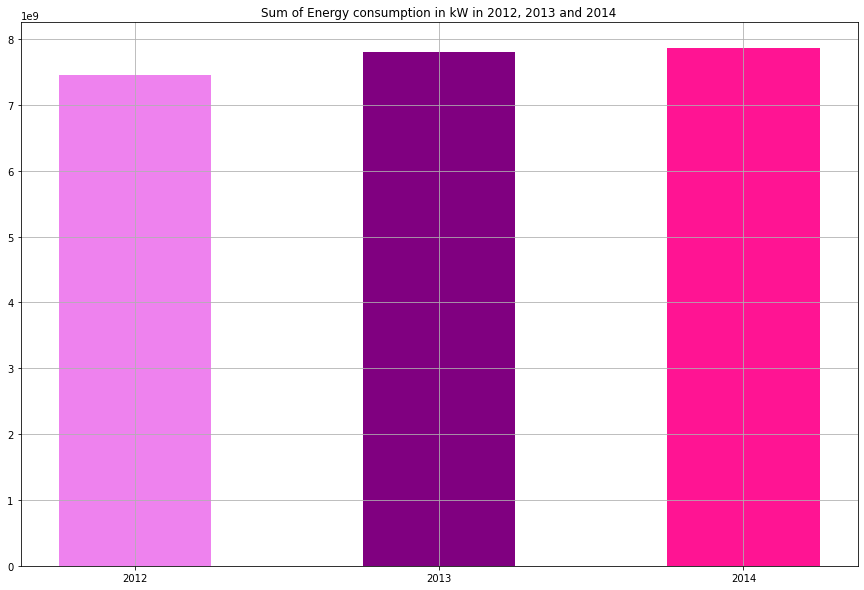

In [10]:
# Plot styling
plt.figure(figsize=(15, 10))
plt.title("Sum of Energy consumption in kW in 2012, 2013 and 2014")

plt.bar(years, sums, color=['violet', 'purple', 'deeppink'], width = 0.5)
plt.grid()
plt.show


In [11]:
# Group by year
dt1 = data.groupby('Year').mean()
dt1

MT_001     MT_002    MT_003      MT_004     MT_005      MT_006  \
Year                                                                     
2012  5.496698  26.842841  7.750324   99.668929  47.163530  185.883577   
2013  6.324027  29.535317  2.200142  108.006935  49.765773  192.505504   
2014  4.058161  26.678553  1.709477  121.009091  52.002346  186.390129   

        MT_007      MT_008     MT_009     MT_010  ...      MT_361  \
Year                                              ...               
2012  4.806117  254.049872  55.001017  53.203680  ...  295.679096   
2013  7.414558  260.241782  54.035348  60.812681  ...  291.472436   
2014  5.863605  251.135499  50.822087  54.772119  ...  285.485661   

            MT_362       MT_363       MT_364      MT_365     MT_366  \
Year                                                                  
2012  53383.956626  2798.317376  4071.638516  101.108481  12.780865   
2013  48697.308790  2461.028505  4028.794365   77.287979  13.106546   
2014  48306.669521  2287.827775  3656.566521   83.157561  11.181687   

          MT_367      MT_368      MT_369        MT_370  
Year                                                    
2012  582.790653  124.669636  859.719076      0.000000  
2013  543.156824  128.245897  829.852665  17199.134426  
2014  570.651878  125.817477  810.773611  17713.979390  

[3 rows x 370 columns]

- Average of yearly consumption visualization

- For 2012 (please download the image and zoom in):

<function matplotlib.pyplot.show(close=None, block=None)>

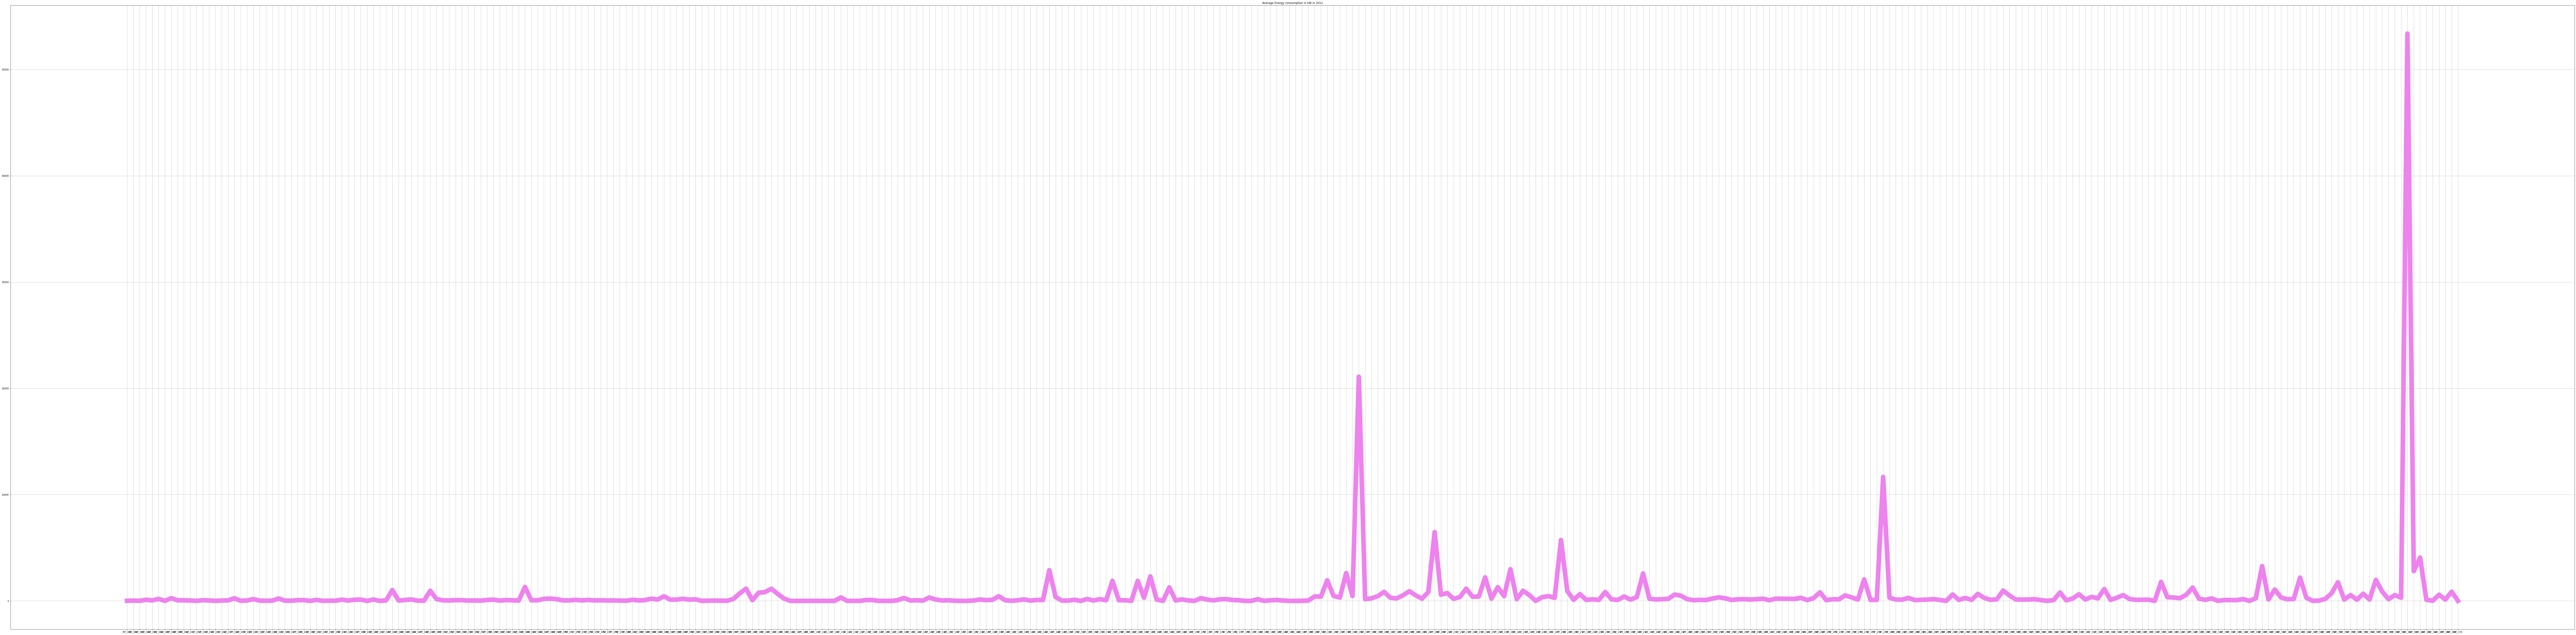

In [12]:
# Plot styling
plt.figure(figsize=(200,50))
plt.title("Average Energy consumption in kW in 2012")

plt.plot(dt1.iloc[0, 0:370], color="violet", marker='o', linewidth='20')
plt.grid()
plt.show


- For 2013 (please download the image and zoom in):

<function matplotlib.pyplot.show(close=None, block=None)>

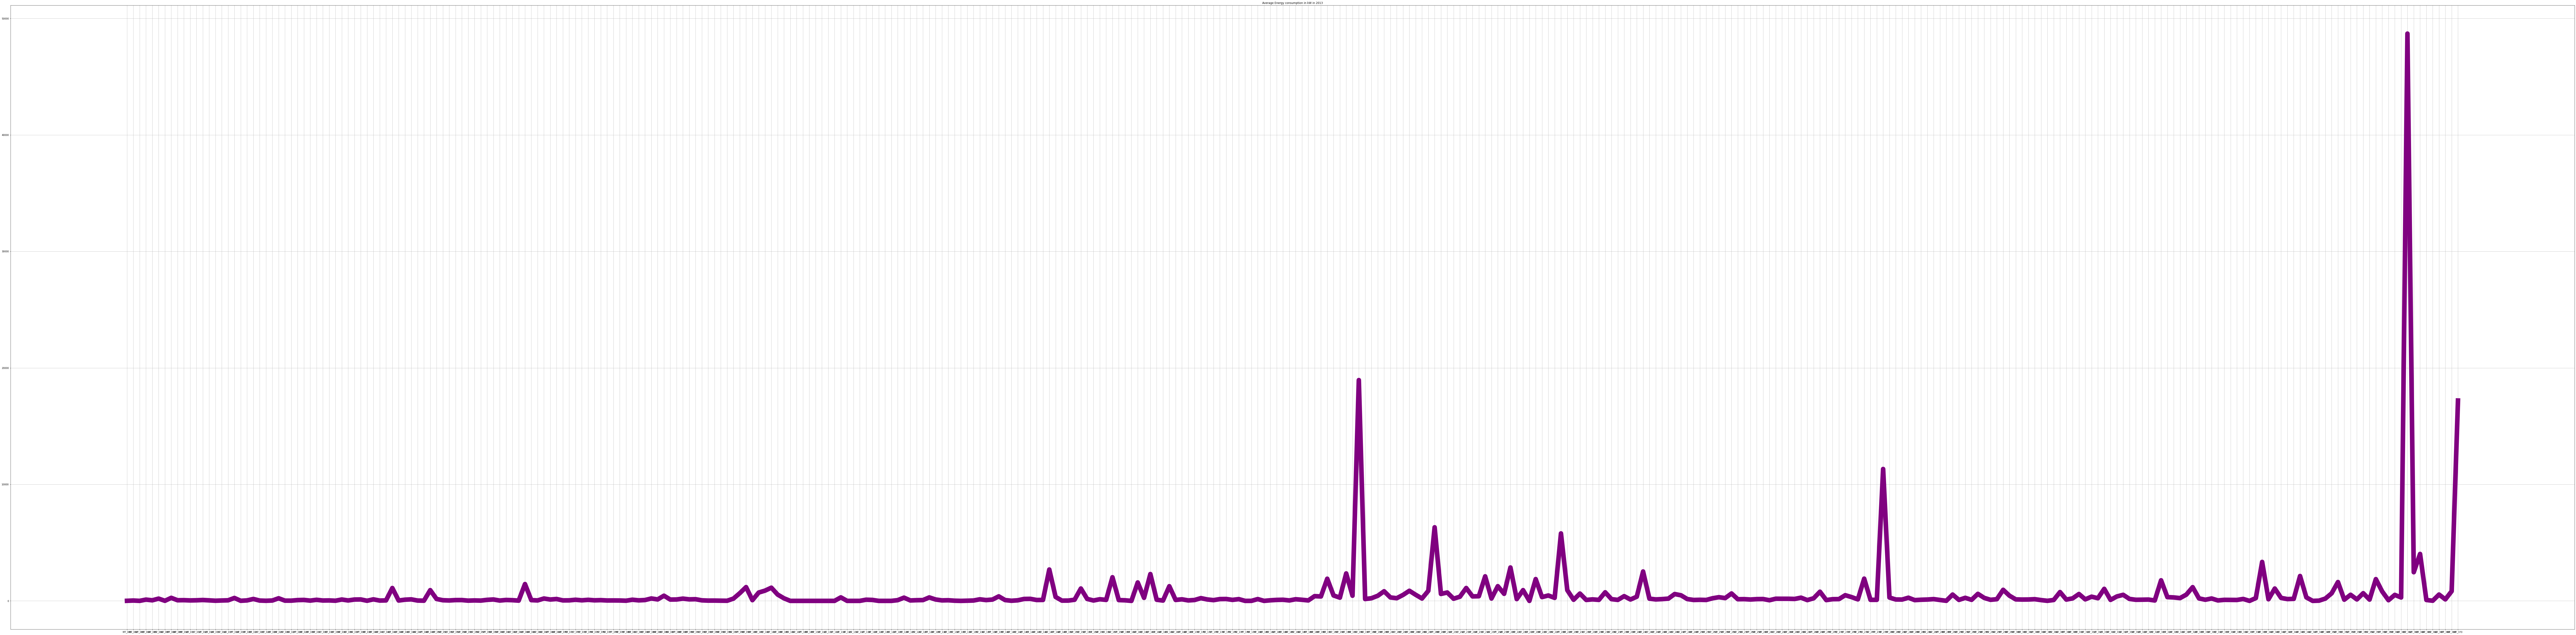

In [13]:
# Plot styling
plt.figure(figsize=(200,50))
plt.title("Average Energy consumption in kW in 2013")

plt.plot(dt1.iloc[1, 0:370], color="purple", marker='o', linewidth='20')
plt.grid()
plt.show

- For 2013 (please download the image and zoom in):

<function matplotlib.pyplot.show(close=None, block=None)>

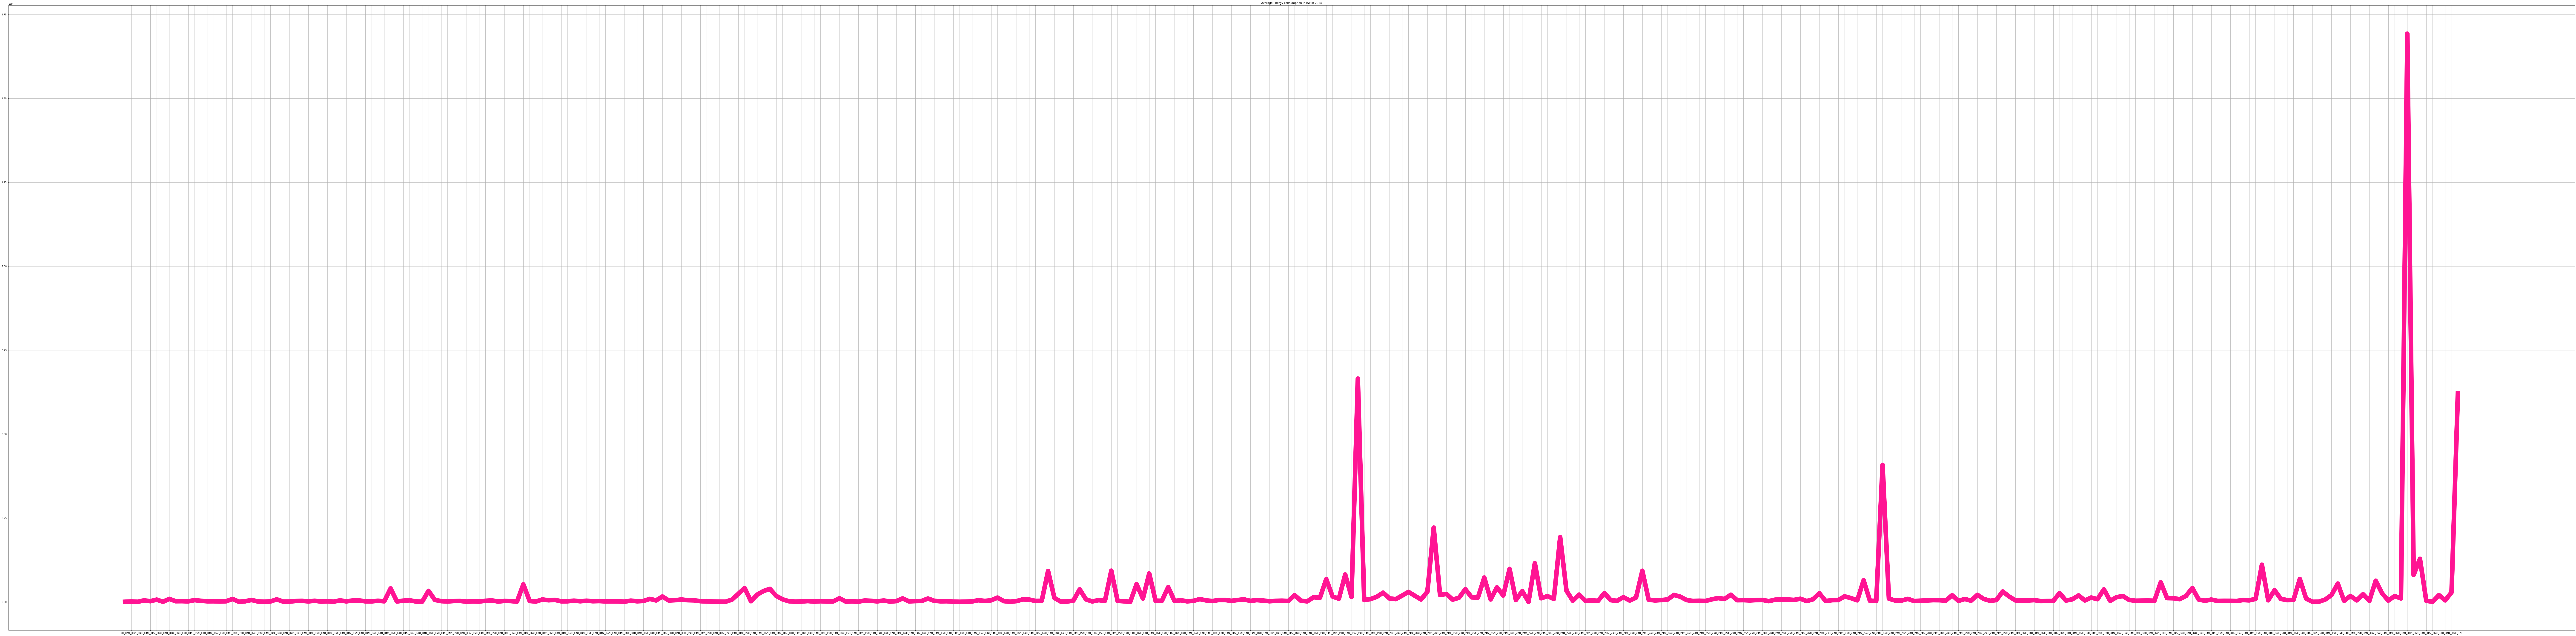

In [14]:
# Plot styling
plt.figure(figsize=(200,50))
plt.title("Average Energy consumption in kW in 2014")

plt.plot(dt.iloc[2, 0:370], color="deeppink", marker='o', linewidth='20')
plt.grid()
plt.show

- Sum of consumption per 15 minutes

In [37]:
# Group by year
dtt = data.groupby('Time').sum()
dtt

MT_001        MT_002       MT_003         MT_004        MT_005  \
Time                                                                            
00:00:00  5220.812183  27830.725462  4197.219809  135083.333333  64703.658537   
00:15:00  5182.741117  27917.496444  4634.231103  129855.691057  62017.073171   
00:30:00  5319.796954  26526.315789  4741.094700  125463.414634  59592.682927   
00:45:00  5341.370558  26232.574680  4794.092094  121451.219512  57886.585366   
01:00:00  5404.822335  25237.553343  4867.940921  115636.178862  56150.000000   
...               ...           ...          ...            ...           ...   
22:45:00  5983.502538  28764.580370  4474.370113  166524.390244  75067.073171   
23:00:00  6039.340102  28691.322902  4297.132928  159197.154472  73842.682927   
23:15:00  6073.604061  28552.631579  4221.546481  151530.487805  71931.707317   
23:30:00  5918.781726  27688.477952  4240.660295  146310.975610  69435.365854   
23:45:00  5468.274112  27924.608819  4141.615986  140731.707317  67225.609756   

                 MT_006       MT_007         MT_008        MT_009  \
Time                                                                
00:00:00  208127.976190  7776.710006  268319.865320  57190.559441   
00:15:00  195404.761905  7477.671001  257888.888889  55398.601399   
00:30:00  186651.785714  7259.468626  250111.111111  53987.762238   
00:45:00  179205.357143  7105.144149  242437.710438  52389.860140   
01:00:00  170181.547619  6925.381572  235693.602694  51319.930070   
...                 ...          ...            ...           ...   
22:45:00  265794.642857  8755.794234  313892.255892  68050.699301   
23:00:00  256919.642857  8588.468061  305737.373737  66337.412587   
23:15:00  243892.857143  8392.312041  296589.225589  63417.832168   
23:30:00  230854.166667  8266.817411  287814.814815  60594.405594   
23:45:00  219833.333333  7989.259469  277720.538721  58230.769231   

                MT_010  ...      MT_362        MT_363        MT_364  \
Time                    ...                                           
00:00:00  57466.666667  ...  41736600.0  1.596975e+06  2.127136e+06   
00:15:00  55933.333333  ...  37250600.0  1.206540e+06  1.902841e+06   
00:30:00  54900.000000  ...  31889600.0  1.158051e+06  1.773341e+06   
00:45:00  53627.956989  ...  28203500.0  1.016844e+06  1.595023e+06   
01:00:00  52733.333333  ...  24001400.0  9.861097e+05  1.555818e+06   
...                ...  ...         ...           ...           ...   
22:45:00  66603.225806  ...  67772900.0  2.679831e+06  3.860273e+06   
23:00:00  65139.784946  ...  61685600.0  2.543814e+06  3.700818e+06   
23:15:00  62555.913978  ...  55917700.0  2.371215e+06  3.249909e+06   
23:30:00  60627.956989  ...  49275600.0  2.127814e+06  2.716114e+06   
23:45:00  58784.946237  ...  44937600.0  1.717709e+06  2.224250e+06   

                 MT_365        MT_366         MT_367         MT_368  \
Time                                                                  
00:00:00   39468.057366  18954.944412  732360.842845  163143.572621   
00:15:00   35518.904824  18425.980105  715701.492537  169005.008347   
00:30:00   32728.813559  17542.422469  710472.344162  165969.949917   
00:45:00   31739.243807  17608.543008  702880.597015  162200.333890   
01:00:00   31113.428944  18015.213575  694446.883231  158388.981636   
...                 ...           ...            ...            ...   
22:45:00  121118.644068  19061.439438  769739.244952  164373.956594   
23:00:00  114900.912647  18801.638385  766614.574188  161878.130217   
23:15:00   91533.246415  18994.733762  756640.913082  160405.676127   
23:30:00   61831.812256  18437.682855  752235.294118  157629.382304   
23:45:00   44754.889179  18886.483324  743098.331870  155530.884808   

                 MT_369        MT_370     Year  
Time                                            
00:00:00  912126.832845  1.264661e+07  2206247  
00:15:00  908911.290323  1.275035e+07  2206247  
00:30:00  888072.58

In [42]:
s = []
for i in range(len(dtt)):
    s.append(dtt.iloc[i, 0:370].sum())
s

[187367149.52762073,
 176210010.0784608,
 164088756.51878503,
 153241186.61656907,
 146771198.20883244,
 143416489.18945274,
 140006081.56143844,
 138694146.4537503,
 138108383.2305281,
 137266388.8890162,
 134885811.51348427,
 134204311.76668198,
 133289109.32594293,
 132764952.36205226,
 130246426.82445177,
 129134542.00959638,
 127986332.82389054,
 128576292.88274845,
 129180893.01520598,
 128821728.1666426,
 128577982.09591067,
 132821925.7112642,
 136027726.43022132,
 137931153.68971962,
 139105701.62414402,
 149604514.11218336,
 154489280.6363818,
 156526408.2488005,
 159573903.79084706,
 167869280.71284327,
 170844857.8352763,
 169426006.6355891,
 169308196.4688607,
 174040030.25016552,
 181120751.51675618,
 192107390.21627766,
 206348960.59464315,
 227160432.85389167,
 250582742.44611946,
 254714372.99400565,
 263492449.61508203,
 275857313.9555325,
 292706292.39432824,
 291278418.1714131,
 295118143.35488045,
 298855434.0378829,
 300519221.2883184,
 301367717.53907657,
 304641

<function matplotlib.pyplot.show(close=None, block=None)>

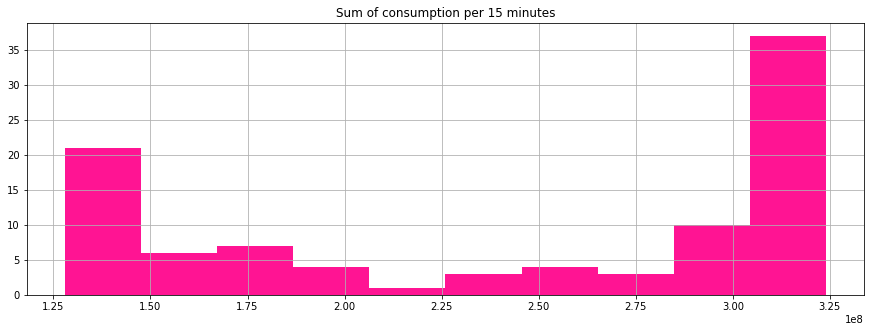

In [54]:
# Plot styling
plt.figure(figsize=(15,5))
plt.title("Sum of consumption per 15 minutes")

plt.hist(s, color="deeppink")
plt.grid()
plt.show


Data Scaling

In [16]:
# Counting the numerical colmns in the dataset and extract them into a dataframe
numeric_columns = data.iloc[:, :370]
numeric_columns.reset_index(drop=True, inplace=True)
numeric_columns.head()

MT_001     MT_002     MT_003      MT_004     MT_005      MT_006  \
0  0.000000   0.000000   0.000000    0.000000   0.000000    0.000000   
1  3.807107  22.759602  77.324066  136.178862  70.731707  351.190476   
2  5.076142  22.759602  77.324066  136.178862  73.170732  354.166667   
3  3.807107  22.759602  77.324066  140.243902  69.512195  348.214286   
4  3.807107  22.759602  77.324066  140.243902  75.609756  339.285714   

     MT_007      MT_008     MT_009     MT_010  ...      MT_361   MT_362  \
0  0.000000    0.000000   0.000000   0.000000  ...    0.000000      0.0   
1  9.609949  279.461279  75.174825  87.096774  ...  128.479657  28500.0   
2  9.044658  279.461279  73.426573  84.946237  ...  127.765882  26400.0   
3  8.479367  279.461279  75.174825  91.397849  ...  114.204140  25200.0   
4  7.348785  279.461279  68.181818  88.172043  ...  112.062812  23800.0   

        MT_363       MT_364     MT_365     MT_366      MT_367     MT_368  \
0     0.000000     0.000000   0.000000   0.000000    0.000000   0.000000   
1  1729.957806  1704.545455  15.645372  12.873025  504.828797  63.439065   
2  1654.008439  1659.090909  15.645372  13.458163  525.021949  60.100167   
3  1333.333333  1636.363636  15.645372  10.532475  526.777875  56.761269   
4  1324.894515  1636.363636  15.645372  14.628438  539.947322  63.439065   

       MT_369  MT_370  
0    0.000000     0.0  
1  761.730205     0.0  
2  702.346041     0.0  
3  696.480938     0.0  
4  693.548387     0.0  

[5 rows x 370 columns]

In [17]:
test = numeric_columns.sum(axis=1)
test

0          60672.234020
1         120371.432507
2         118439.493091
3         117438.815666
4         114412.922578
              ...      
105211    137023.682306
105212    132288.754939
105213    128543.516567
105214    127478.208411
105215    125641.710272
Length: 105216, dtype: float64

In [18]:
# Initialize a minmax scaler 
scaler_test = sklearn.preprocessing.MinMaxScaler(feature_range=(0,1))

# Scale the dataframe
df_scaled_test = scaler_test.fit_transform(test.to_numpy().reshape(-1, 1))
df_scaled_test = pd.DataFrame(df_scaled_test)
df_scaled_test

0
0       0.133381
1       0.265369
2       0.261097
3       0.258885
4       0.252195
...          ...
105211  0.302185
105212  0.291716
105213  0.283436
105214  0.281081
105215  0.277020

[105216 rows x 1 columns]

In [19]:
# Concatenate with the rest of the columns
rest = data.iloc[:, 370:]
rest.reset_index(drop=True, inplace=True)
frames = [df_scaled_test, rest]
scaled_data = pd.concat(frames, axis=1)


In [20]:
scaled_data.head()

0        Date      Time  Year
0  0.133381  2012-01-01  00:00:00  2012
1  0.265369  2012-01-01  00:15:00  2012
2  0.261097  2012-01-01  00:30:00  2012
3  0.258885  2012-01-01  00:45:00  2012
4  0.252195  2012-01-01  01:00:00  2012

Train and Test sets

In [21]:
def load_data(stock, seq_len):
    train_size = int(stock.shape[0] * 0.9)
    X_train = []
    y_train = []
    for i in range(seq_len, len(stock)):
        X_train.append(stock.iloc[i-seq_len : i, 0])
        y_train.append(stock.iloc[i, 0])
    
    X_test = X_train[train_size:]             
    y_test = y_train[train_size:]
    
    X_train = X_train[:train_size]           
    y_train = y_train[:train_size]
    
    X_train = np.array(X_train)
    y_train = np.array(y_train)
    
    X_test = np.array(X_test)
    y_test = np.array(y_test)
    
    X_train = np.reshape(X_train, (train_size, seq_len, 1))
    
    X_test = np.reshape(X_test, (X_test.shape[0], seq_len, 1))
    
    return [X_train, y_train, X_test, y_test]


In [22]:
#create train, test data
seq_len = 20 #choose sequence length

X_train, y_train, X_test, y_test = load_data(scaled_data, seq_len)

print('X_train.shape = ',X_train.shape)
print('y_train.shape = ', y_train.shape)
print('X_test.shape = ', X_test.shape)
print('y_test.shape = ',y_test.shape)

X_train.shape =  (94694, 20, 1)
y_train.shape =  (94694,)
X_test.shape =  (10502, 20, 1)
y_test.shape =  (10502,)


RNN Model

In [23]:
rnn_model = Sequential()

rnn_model.add(SimpleRNN(40,activation="tanh",return_sequences=True, input_shape=(X_train.shape[1],1)))
rnn_model.add(Dropout(0.15))

rnn_model.add(SimpleRNN(40,activation="tanh",return_sequences=True))
rnn_model.add(Dropout(0.15))

rnn_model.add(SimpleRNN(40,activation="tanh",return_sequences=False))
rnn_model.add(Dropout(0.15))

rnn_model.add(Dense(1))

rnn_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn (SimpleRNN)      (None, 20, 40)            1680      
                                                                 
 dropout (Dropout)           (None, 20, 40)            0         
                                                                 
 simple_rnn_1 (SimpleRNN)    (None, 20, 40)            3240      
                                                                 
 dropout_1 (Dropout)         (None, 20, 40)            0         
                                                                 
 simple_rnn_2 (SimpleRNN)    (None, 40)                3240      
                                                                 
 dropout_2 (Dropout)         (None, 40)                0         
                                                                 
 dense (Dense)               (None, 1)                 4

In [24]:
rnn_predictions = rnn_model.predict(X_test)

rnn_score = r2_score(y_test,rnn_predictions)
print("R2 Score of RNN model = ",rnn_score)
print("MSE of RNN model = ", mean_squared_error(y_test, rnn_predictions))

329/329 [==============================] - 2s 4ms/step
R2 Score of RNN model =  -4.431449240430363
MSE of RNN model =  0.13527788482003242


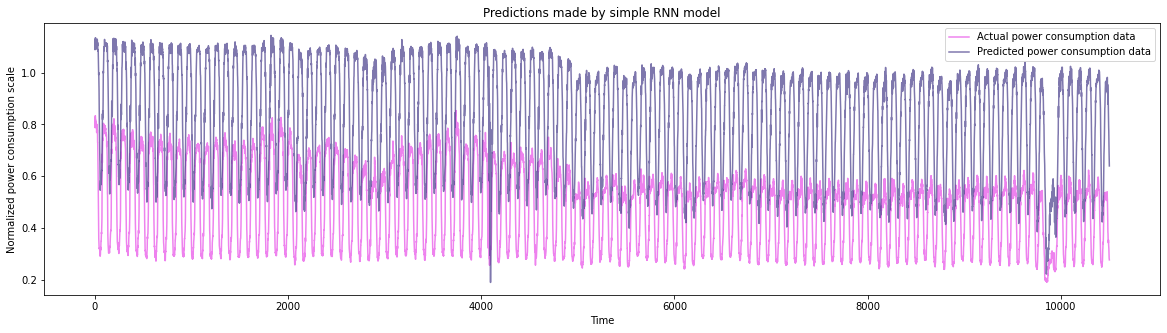

In [25]:
# Plot function

def plot_predictions(test, predicted, title):
    plt.figure(figsize=(20,5))
    plt.plot(test, color='violet',label='Actual power consumption data')
    plt.plot(predicted, alpha=0.7, color='darkslateblue',label='Predicted power consumption data')
    plt.title(title)
    plt.xlabel('Time')
    plt.ylabel('Normalized power consumption scale')
    plt.legend()
    plt.show()
    
plot_predictions(y_test, rnn_predictions, "Predictions made by simple RNN model")


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


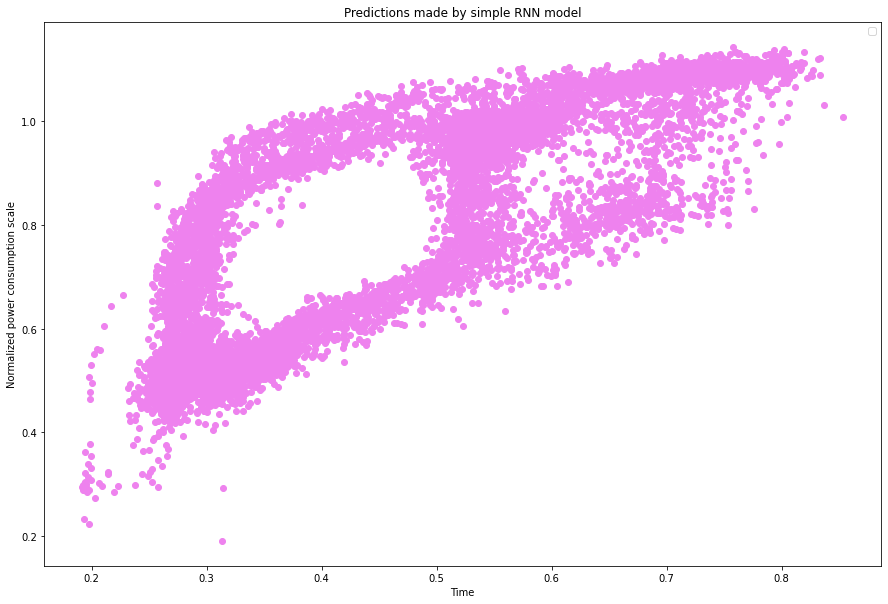

In [26]:
# Scatter plot function
def scatter_plot_predictions(test, predicted, title):
    plt.figure(figsize=(15, 10))
    plt.scatter(test, predicted, color='violet')
    plt.title(title)
    plt.xlabel('Time')
    plt.ylabel('Normalized power consumption scale')
    plt.legend()
    plt.show()
    
scatter_plot_predictions(y_test, rnn_predictions, "Predictions made by simple RNN model")


LSTM Model

In [27]:
lstm_model = Sequential()

lstm_model.add(LSTM(40,activation="tanh",return_sequences=True, input_shape=(X_train.shape[1],1)))
lstm_model.add(Dropout(0.15))

lstm_model.add(LSTM(40,activation="tanh",return_sequences=True))
lstm_model.add(Dropout(0.15))

lstm_model.add(LSTM(40,activation="tanh",return_sequences=False))
lstm_model.add(Dropout(0.15))

lstm_model.add(Dense(1))

lstm_model.summary()



Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 20, 40)            6720      
                                                                 
 dropout_3 (Dropout)         (None, 20, 40)            0         
                                                                 
 lstm_1 (LSTM)               (None, 20, 40)            12960     
                                                                 
 dropout_4 (Dropout)         (None, 20, 40)            0         
                                                                 
 lstm_2 (LSTM)               (None, 40)                12960     
                                                                 
 dropout_5 (Dropout)         (None, 40)                0         
                                                                 
 dense_1 (Dense)             (None, 1)                

In [28]:
lstm_model.compile(optimizer="adam",loss="MSE")
lstm_model.fit(X_train, y_train, epochs=10, batch_size=1000)


Epoch 1/10
95/95 [==============================] - 22s 175ms/step - loss: 0.0254
Epoch 2/10
95/95 [==============================] - 16s 163ms/step - loss: 0.0062
Epoch 3/10
95/95 [==============================] - 17s 174ms/step - loss: 0.0042
Epoch 4/10
95/95 [==============================] - 16s 163ms/step - loss: 0.0038
Epoch 5/10
95/95 [==============================] - 16s 163ms/step - loss: 0.0034
Epoch 6/10
95/95 [==============================] - 17s 180ms/step - loss: 0.0031
Epoch 7/10
95/95 [==============================] - 16s 172ms/step - loss: 0.0029
Epoch 8/10
95/95 [==============================] - 16s 170ms/step - loss: 0.0027
Epoch 9/10
95/95 [==============================] - 16s 168ms/step - loss: 0.0025
Epoch 10/10
95/95 [==============================] - 18s 192ms/step - loss: 0.0024


In [29]:
lstm_predictions = lstm_model.predict(X_test)

lstm_score = r2_score(y_test, lstm_predictions)
print("R^2 Score of LSTM model = ",lstm_score)
print("MSE of LSTM model = ", mean_squared_error(y_test, lstm_predictions))


329/329 [==============================] - 3s 7ms/step
R^2 Score of LSTM model =  0.959080842531289
MSE of LSTM model =  0.00101914918577909


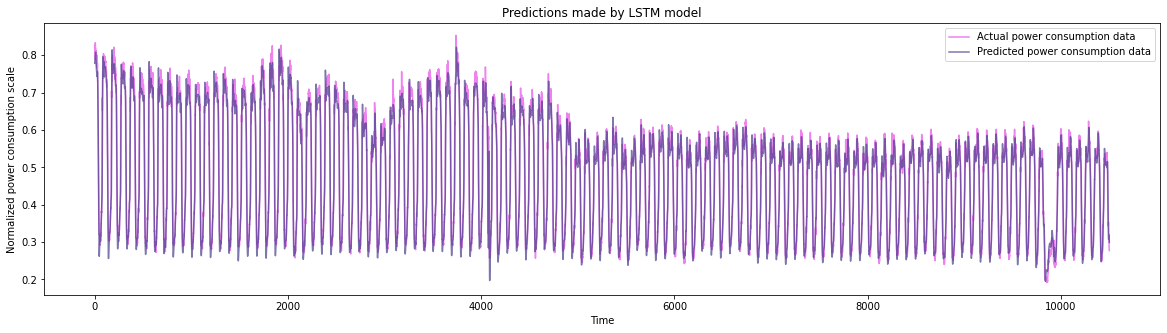

In [30]:
plot_predictions(y_test, lstm_predictions, "Predictions made by LSTM model")

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


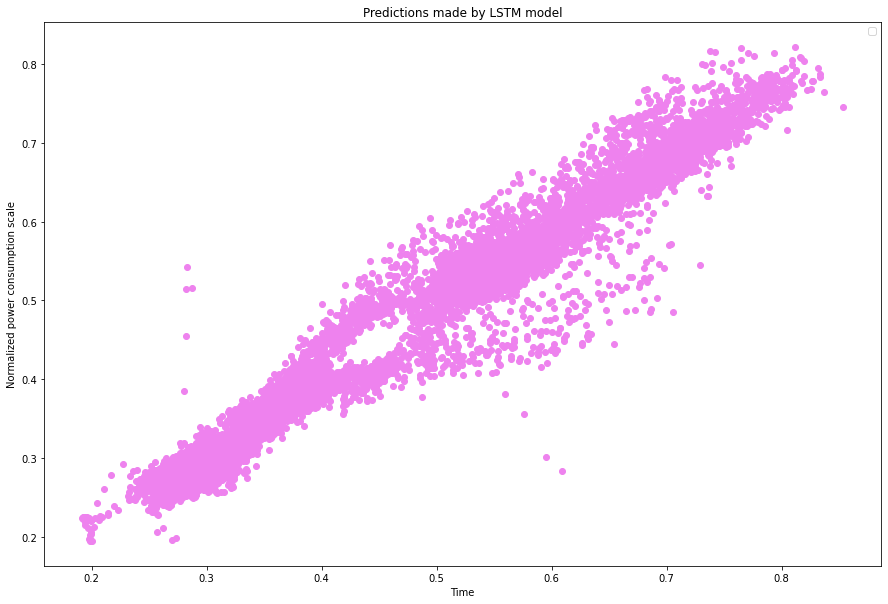

In [31]:
scatter_plot_predictions(y_test, lstm_predictions, "Predictions made by LSTM model")

Linear Regression

In [32]:
lr = LinearRegression()

# reshaping X_train and X_test to be 2d
nsamples, nx, ny = X_train.shape
d2_X_train = X_train.reshape((nsamples,nx*ny))
nsamples, nx, ny = X_test.shape
d2_X_test = X_test.reshape((nsamples,nx*ny))

lr.fit(d2_X_train, y_train)
lr_predictions = lr.predict(d2_X_test)

lr_score  = r2_score(y_test,lr_predictions)
print("R^2 Score of Linear Regression model = ",lr_score)
print("MSE of Linear Regression model = ", mean_squared_error(y_test, lr_predictions))

R^2 Score of Linear Regression model =  0.988567276823826
MSE of Linear Regression model =  0.0002847480553612314


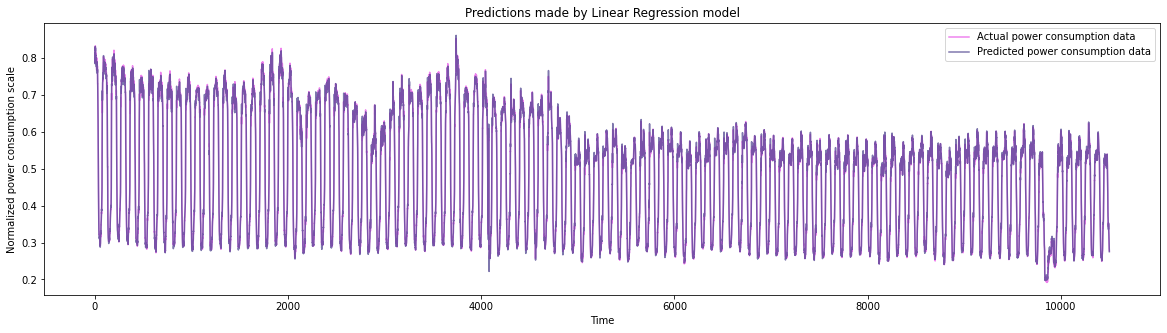

In [33]:
plot_predictions(y_test, lr_predictions, "Predictions made by Linear Regression model")

Please read the report for the cells below.

Short-term forecasting

In [34]:
# # Import dataset
# test_data = pd.read_csv('test.txt', sep=';', thousands='.', decimal=',')
# # Show first five rows
# test_data.head()

Datetime  Consumption
0  2015-01-01 00:15:00          NaN
1  2015-01-01 00:30:00          NaN
2  2015-01-01 00:45:00          NaN
3  2015-01-01 01:00:00          NaN
4  2015-01-01 01:15:00          NaN

In [35]:
# the first 3 hours for short term forecasting
# data_short = test_data[:12]
# data_short

Datetime  Consumption
0   2015-01-01 00:15:00          NaN
1   2015-01-01 00:30:00          NaN
2   2015-01-01 00:45:00          NaN
3   2015-01-01 01:00:00          NaN
4   2015-01-01 01:15:00          NaN
5   2015-01-01 01:30:00          NaN
6   2015-01-01 01:45:00          NaN
7   2015-01-01 02:00:00          NaN
8   2015-01-01 02:15:00          NaN
9   2015-01-01 02:30:00          NaN
10  2015-01-01 02:45:00          NaN
11  2015-01-01 03:00:00          NaN

In [ ]:
# short_predictions = lr.predict(data_short)

Long-term forecasting

In [ ]:
# long_predictions = lr.predict(test_data)